In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Dense, Input, Flatten, Lambda
from keras.losses import binary_crossentropy, MeanSquaredError
from keras import Model
from keras import backend as K
import numpy as np
from tqdm import tqdm
print(f"Using Tensorflow v{tf.__version__}")

2023-03-27 13:35:49.577536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 13:35:50.820637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64::/home/jeremy/anaconda3/envs/tf/lib/
2023-03-27 13:35:50.820830: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64::/home/jeremy/anaconda3/envs/tf/lib/
2023-03-27 1

Using Tensorflow v2.11.0


In [2]:
def normalize(tensor):
    tensor_minusmin = tensor - tensor.min()
    tensor_maxminusmin = tensor.max() - tensor.min()
    return tensor_minusmin / tensor_maxminusmin

def get_waves(file_name):
    # Read the raw audio from the .WAV file
    raw_audio = tf.io.read_file(filename=file_name)
    # Convert the raw audio to a waveform
    wave_bank, sample_rate = tf.audio.decode_wav(raw_audio)
    # Display the wavebank and sample_rate
    # display(wave_bank, sample_rate)
    wave_size = 256
    num_waves = 0
    waves = []
    wave_forms = np.transpose(wave_bank.numpy())
    for i in range(64):
        wave_form = wave_forms[0, i*wave_size:i*wave_size+wave_size]
        if wave_form.max() != wave_form.min():
            wave_form = normalize(wave_form)
            waves.append(wave_form)
            num_waves += 1    
    waves = tf.stack(waves)
    return waves

In [3]:
enc_input_shape = (256,1,1)
latent_dim = 16
encoder = Sequential([
    Input(enc_input_shape, name="encoder_input"),
    Conv2D(filters=16, kernel_size=(4,1), 
           strides=(2,1), padding="same",
           activation="relu", name="conv2d_1"
    ),
    Conv2D(filters=32, kernel_size=(4,1),
           strides=(2,1), padding="same",
           activation="relu", name="conv2d_2"
    ),
    Reshape((1,-1), name="reshape"),
    Dense(latent_dim+latent_dim, name="mu")
], name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 1, 16)        80        
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 1, 32)         2080      
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 mu (Dense)                  (None, 1, 32)             65568     
                                                                 
Total params: 67,728
Trainable params: 67,728
Non-trainable params: 0
_________________________________________________________________


2023-03-27 13:35:58.018900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 13:35:58.076558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 13:35:58.077114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-27 13:35:58.077861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [4]:
enc_input_shape = (1,256,1,1)
latent_dim = 16

class Encoder(Model):
    name="encoder"
    def __init__(self):
        super().__init__()
        self.training = True
        self.conv1 = Conv2D(filters=16, kernel_size=(4,1), 
                            strides=(2,1), padding="same",
                            activation="relu", name="conv2d_1")
        self.conv2 = Conv2D(filters=32, kernel_size=(4,1),
                            strides=(2,1), padding="same",
                            activation="relu", name="conv2d_2"
                            )
        self.flatten = Reshape((1,-1), name="flatten")
        self.mu = Dense(latent_dim, name="mu")
        self.log_var = Dense(latent_dim, name="log_var")
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        temp = self.flatten(x)
        mu = self.mu(temp)
        log_var = self.log_var(temp)
        if self.training:
            return [mu,log_var]
        else:
            return mu
    
    def eval(self):
        training = False     

In [5]:
dec_input_shape = (1,1,16,1)
latent_dim = 16

class Decoder(Model):
    name="decoder"
    def __init__(self):
        super().__init__()
        
        self.training = True
        self.dense = Dense(128, name='decoder_dense_1')
        self.reshape = Reshape((1,64,-1), name="decoder_reshape")
        self.conv1T = Conv2DTranspose(filters=16, kernel_size=(1,4),
                                      strides=(1,2), padding="same",
                                      activation="relu", name="conv2dT_1")
        self.conv2T = Conv2DTranspose(filters=1, kernel_size=(1,4), 
                                      strides=(1,2), padding="same",
                                      activation="sigmoid", name="decoder_output")
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        x = self.conv1T(x)
        x = self.conv2T(x)
        return x
    
    def eval(self):
        training = False        

In [6]:
class VAE(Model):
    name = "vae"
    wave_size = 256
    def __init__(self):
        super().__init__()
        self.training = True
        self.variational_beta = 1
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, inputs):
        x = self.encoder(inputs)
        sampled_point = self.sample_normal_point(x[0],x[1])
        sampled_point = tf.expand_dims(sampled_point, -1)
        return self.decoder(sampled_point)
    
    def sample_normal_point(self, mu, log_var):
        if self.training:
            self.mu = mu
            self.log_var = log_var
            std = tf.math.exp(log_var/2)
            epsilon = K.random_normal(shape=K.shape(mu), stddev=std)
            sampled_point = mu + std * epsilon
            return sampled_point
        else:
            return mu
    
    def loss(self, y_true, y_pred):
        recon_loss = binary_crossentropy( 
                                         tf.reshape(y_true,(-1,self.wave_size)), 
                                         tf.reshape(y_pred,(-1,self.wave_size))
                                         )
        recon_loss = tf.reduce_sum(recon_loss)
        # return recon_loss
        
        kl_loss = -0.5 * K.sum( 1 + self.log_var - K.pow(self.mu,2) - K.exp(self.log_var))
        
        tv_loss = K.sum(K.pow(y_pred[:,:,:-1] - y_pred[:,:,1:],2))
        
        return recon_loss
        # return 10000*recon_loss + self.variational_beta * kl_loss + 100.1*tv_loss
        
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.training = False

In [7]:
waves = get_waves("./audio_data/ENVELO01.WAV")
waves = tf.expand_dims(waves, 1)
waves = tf.expand_dims(waves, -1)
waves = tf.expand_dims(waves, -1)
display(waves[0].shape)

TensorShape([1, 256, 1, 1])

In [8]:
vae = VAE()
vae.encoder.build(enc_input_shape)
vae.decoder.build(dec_input_shape)
vae.build(enc_input_shape)
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  67728     
                                                                 
 decoder (Decoder)           multiple                  2385      
                                                                 
Total params: 70,113
Trainable params: 70,113
Non-trainable params: 0
_________________________________________________________________


In [9]:
vae.compile(optimizer='adam', loss=vae.loss)
vae.fit(waves, waves,
                epochs=5000,
                shuffle=True,
                validation_data=(waves, waves))

Epoch 1/5000


2023-03-27 13:36:37.126615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-27 13:36:39.135772: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fdc7daad670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-27 13:36:39.135796: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2023-03-27 13:36:39.150444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-27 13:36:39.317841: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 6s 288ms/step - loss: 221991.6562 - val_loss: 221245.6250
Epoch 2/5000
2/2 [==============================] - 0s 31ms/step - loss: 220854.2188 - val_loss: 220014.5938
Epoch 3/5000
2/2 [==============================] - 0s 30ms/step - loss: 219711.7969 - val_loss: 218871.7812
Epoch 4/5000
2/2 [==============================] - 0s 29ms/step - loss: 218554.2031 - val_loss: 217719.7500
Epoch 5/5000
2/2 [==============================] - 0s 30ms/step - loss: 217388.7500 - val_loss: 216446.6875
Epoch 6/5000
2/2 [==============================] - 0s 29ms/step - loss: 216071.9062 - val_loss: 214802.3438
Epoch 7/5000
2/2 [==============================] - 0s 28ms/step - loss: 214457.5625 - val_loss: 213005.5938
Epoch 8/5000
2/2 [==============================] - 0s 29ms/step - loss: 212458.7188 - val_loss: 210313.9844
Epoch 9/5000
2/2 [==============================] - 0s 28ms/step - loss: 209932.9531 - val_loss: 207586.3750
Epoch 10/5000
2/2 [============

In [10]:
vae.eval()

TensorShape([1, 1, 256, 1])

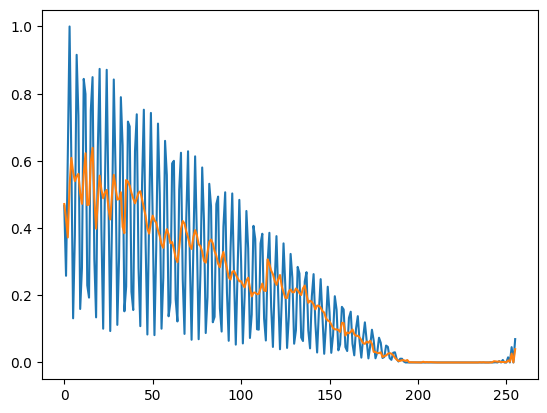

In [11]:
import matplotlib.pyplot as plt
plt.plot(tf.squeeze(waves[0]))
decoded = vae(waves[0])
display(decoded.shape)
plt.plot(tf.squeeze(decoded))

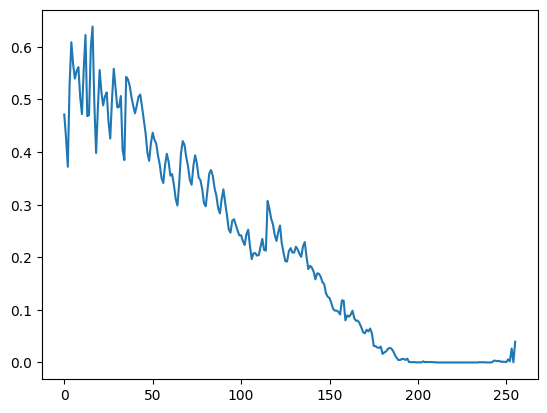

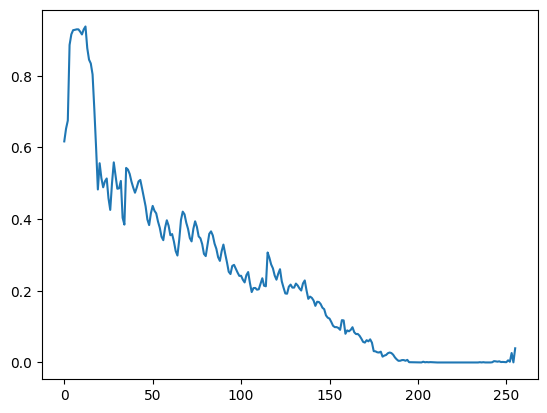

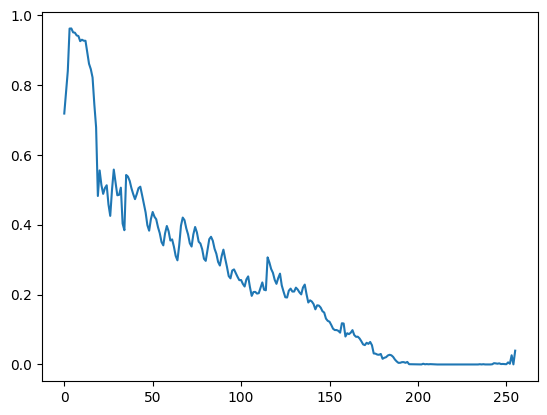

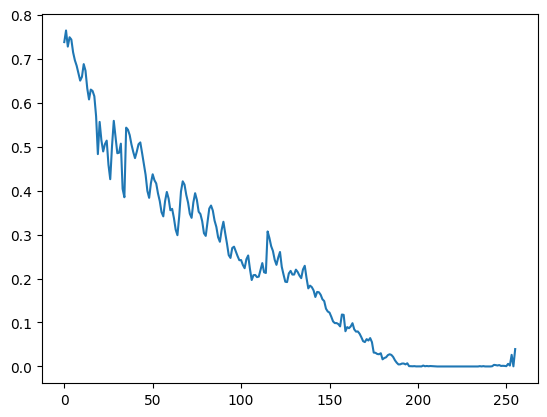

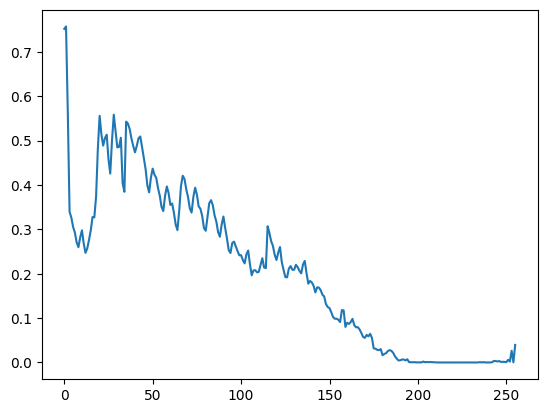

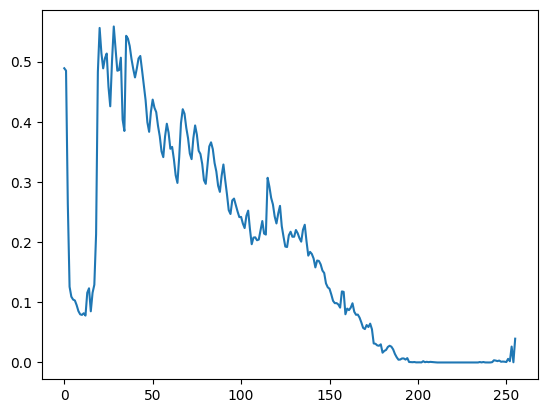

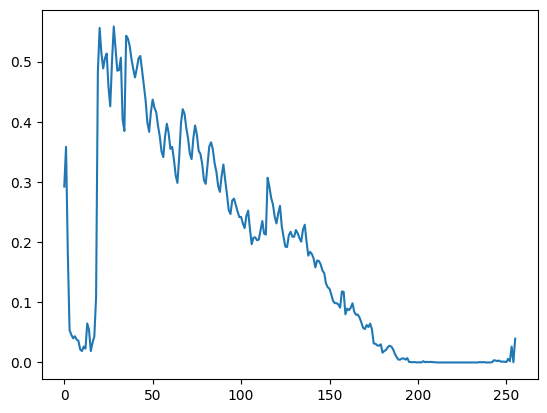

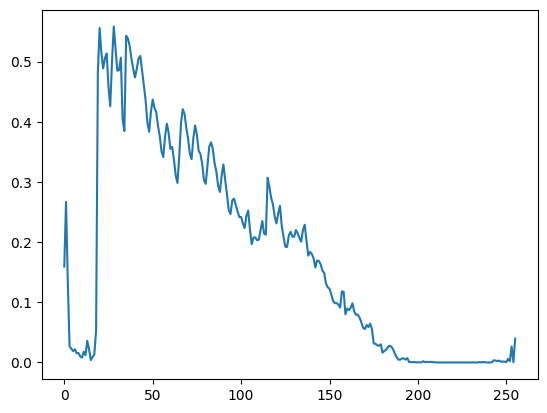

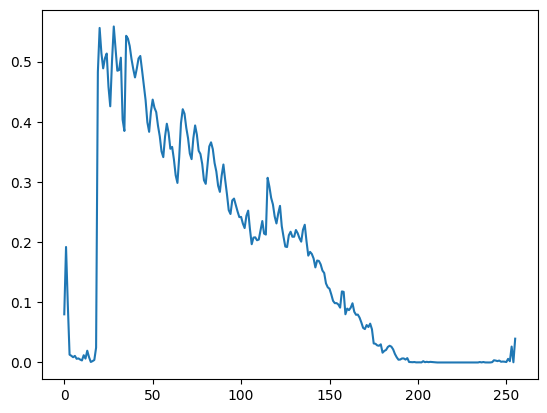

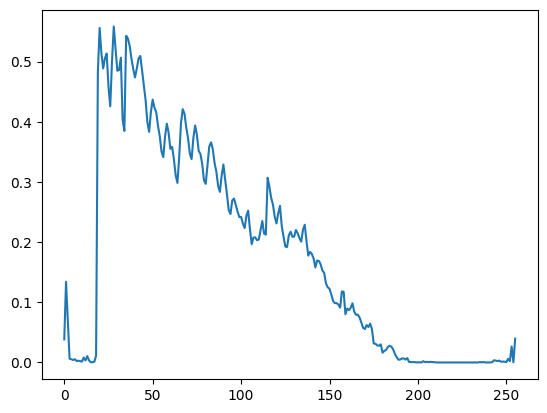

In [50]:
vae.encoder.eval()
encoded = vae.encoder(waves[0])[0]
encoded = tf.expand_dims(encoded, -1)
inc_tensor = np.zeros((1,1,16))
inc_tensor[0,0,0]=0.1
inc_tensor = tf.convert_to_tensor(inc_tensor, dtype='float32')
inc_tensor = tf.expand_dims(inc_tensor, -1)
for i in range(10):
    plt.figure()
    plt.plot(tf.squeeze(vae.decoder(encoded+i*inc_tensor)))

